In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import warnings
import os
import joblib
import json
import time
from tqdm.auto import tqdm

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast  # For mixed-precision (as recommended)

# Scikit-learn & TorchMetrics (as recommended)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torchmetrics.classification import BinaryAUROC, BinaryAveragePrecision
from torchmetrics import MeanSquaredError as TorchMeanSquaredError

# Suppress warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

print("Setup complete. All libraries loaded.")

/home/vulcan/miniconda3/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. All libraries loaded.


In [2]:
# Cell 2: Configuration & Hyperparameters
class Config:
    # File Paths
    ARTIFACTS_DIR = 'artifacts'
    TRAIN_FILE = os.path.join(ARTIFACTS_DIR, 'train_processed.parquet')
    TEST_FILE = os.path.join(ARTIFACTS_DIR, 'test_processed.parquet')
    CARDINALITY_FILE = os.path.join(ARTIFACTS_DIR, 'cardinalities.json')
    
    # Model Architecture (as recommended)
    EMBED_DIM = 32         # Embedding dimension for categories
    N_LAYERS = 4           # Number of transformer layers
    N_HEADS = 8            # Number of attention heads
    NUM_MLP_LAYERS = 2     # Layers in the numerical MLP
    DROPOUT = 0.2          # Dropout rate (as recommended)

    # Training Parameters
    BATCH_SIZE = 2048
    EPOCHS = 30            # Max epochs
    PATIENCE = 5           # Early stopping patience (as recommended)
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-2    # Weight decay for AdamW (as recommended)
    
    # System
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Features (must match your prep script)
    CAT_FEATURES = ['state', 'district_topK', 'pincode_topK', 'month', 'day_of_week']
    NUM_FEATURES = ['age_0_5', 'age_5_17', 'age_18_greater', 'child_ratio', 'adult_ratio', 'dependent_ratio']
    
    # Targets
    T1_TARGET = 'is_anomaly'
    T2_TARGET = 'target_7d'
    T3_TARGET = 'high_inequality'

CONFIG = Config()
print(f"Running on device: {CONFIG.DEVICE}")
print(f"Batch size: {CONFIG.BATCH_SIZE}")

Running on device: cuda
Batch size: 2048


In [3]:
# Cell 3: Seed Everything (for Reproducibility)
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()
print("Set random seeds for reproducibility.")

Set random seeds for reproducibility.


In [4]:
# Cell 4: Load Data and Artifacts
print("Loading processed data and artifacts...")

# Load data (This is where we load the Parquet files you created)
try:
    train_val_df = pd.read_parquet(CONFIG.TRAIN_FILE)
    test_df = pd.read_parquet(CONFIG.TEST_FILE)
except FileNotFoundError:
    print("ERROR: Parquet files not found in 'artifacts/' directory.")
    print("Please ensure you have run the 'Data Preparation' notebook first.")
    raise

# Load cardinalities (for embedding layers)
with open(CONFIG.CARDINALITY_FILE, 'r') as f:
    cardinalities = json.load(f)

# Split train_val_df into train and validation sets
# We use a time-based split (data is already sorted)
val_split_frac = 0.15 # Use 15% for validation (as recommended)
val_split_idx = int(len(train_val_df) * (1 - val_split_frac))

train_df = train_val_df.iloc[:val_split_idx]
val_df = train_val_df.iloc[val_split_idx:]

print(f"  Full train data: {len(train_val_df)} rows")
print(f"  Training split:  {len(train_df)} rows")
print(f"  Validation split: {len(val_df)} rows")
print(f"  Test split:      {len(test_df)} rows")
print(f"  Cardinalities loaded: {cardinalities}")

Loading processed data and artifacts...
  Full train data: 179423 rows
  Training split:  152509 rows
  Validation split: 26914 rows
  Test split:      39668 rows
  Cardinalities loaded: {'state': 37, 'district_topK': 301, 'pincode_topK': 501, 'month': 11, 'day_of_week': 7}


In [5]:
# Cell 5: PyTorch Dataset Class
class TabularDataset(Dataset):
    def __init__(self, df, cat_features, num_features, target_name):
        self.cat_cols = df[cat_features].values.astype(np.int64)
        self.num_cols = df[num_features].values.astype(np.float32)
        self.target = df[target_name].values.astype(np.float32)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.cat_cols[idx], dtype=torch.long),
            torch.tensor(self.num_cols[idx], dtype=torch.float),
            torch.tensor(self.target[idx], dtype=torch.float)
        )

In [6]:
# Cell 6: TabTransformer Model Architecture
# This implements the core ideas: embeddings for categories,
# a transformer block, and an MLP for numerical features.

class TabTransformer(nn.Module):
    def __init__(self, cardinalities, cat_features, num_features, embed_dim,
                 n_layers, n_heads, num_mlp_layers, dropout, out_dim=1):
        super().__init__()
        
        # --- Categorical Embedding ---
        self.category_embeddings = nn.ModuleDict()
        for col in cat_features:
            # Use the correct cardinality from our saved JSON
            self.category_embeddings[col] = nn.Embedding(cardinalities[col], embed_dim)
        
        # --- Transformer Block ---
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=n_layers)

        # --- Numerical Features MLP (with BatchNorm & Dropout as recommended) ---
        n_num = len(num_features)
        num_layers = []
        in_dim = n_num
        for i in range(num_mlp_layers):
            out_dim_mlp = embed_dim * 2 if i == 0 else embed_dim
            num_layers.extend([
                nn.Linear(in_dim, out_dim_mlp),
                nn.ReLU(),
                nn.BatchNorm1d(out_dim_mlp), # As recommended
                nn.Dropout(dropout)         # As recommended
            ])
            in_dim = out_dim_mlp
        self.numerical_mlp = nn.Sequential(*num_layers)

        # --- Final Classifier Head ---
        # We flatten the transformer output by taking the mean
        final_mlp_in_dim = embed_dim + in_dim 
        self.final_mlp = nn.Sequential(
            nn.LayerNorm(final_mlp_in_dim),
            nn.Linear(final_mlp_in_dim, final_mlp_in_dim // 2),
            nn.ReLU(),
            nn.Linear(final_mlp_in_dim // 2, out_dim)
        )

    def forward(self, x_cat, x_num):
        # 1. Process Categorical
        embeddings = []
        for i, col in enumerate(CONFIG.CAT_FEATURES):
            embeddings.append(self.category_embeddings[col](x_cat[:, i]))
        
        x_cat_embed = torch.stack(embeddings, dim=1)
        
        # 2. Pass through Transformer
        x_transformer_out = self.transformer(x_cat_embed)
        
        # 3. Flatten transformer output (mean pooling)
        x_transformer_flat = x_transformer_out.mean(dim=1)
        
        # 4. Process Numerical
        x_num_out = self.numerical_mlp(x_num)
        
        # 5. Concatenate and Classify
        x_concat = torch.cat([x_transformer_flat, x_num_out], dim=1)
        output = self.final_mlp(x_concat)
        
        return output

print("✓ TabTransformer model class defined.")

✓ TabTransformer model class defined.


In [7]:
# Cell 7: Training and Evaluation Loops
def train_one_epoch(model, loader, optimizer, scheduler, criterion, scaler, device):
    model.train()
    total_loss = 0
    
    for x_cat_batch, x_num_batch, y_batch in loader:
        x_cat_batch, x_num_batch, y_batch = (
            x_cat_batch.to(device), 
            x_num_batch.to(device), 
            y_batch.to(device).unsqueeze(1)
        )
        
        optimizer.zero_grad()
        
        # Mixed Precision (as recommended)
        with autocast():
            output = model(x_cat_batch, x_num_batch)
            loss = criterion(output, y_batch)
        
        # Scale loss and backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step() # OneCycleLR steps every batch
        
        total_loss += loss.item()
        
    return total_loss / len(loader)

@torch.no_grad()
def evaluate_model(model, loader, criterion, metrics, device, task_type='classification'):
    model.eval()
    total_loss = 0
    
    # Reset all metrics (as recommended by torchmetrics)
    for metric in metrics.values():
        metric.reset()

    for x_cat_batch, x_num_batch, y_batch in loader:
        x_cat_batch, x_num_batch, y_batch = (
            x_cat_batch.to(device), 
            x_num_batch.to(device), 
            y_batch.to(device)
        )
        
        output = model(x_cat_batch, x_num_batch).squeeze()
        
        if task_type == 'regression':
            y_batch = y_batch.float()
        else:
            y_batch = y_batch.long() # For classification metrics

        # Ensure correct shape for loss
        loss = criterion(output.float(), y_batch.float())
        total_loss += loss.item()

        # Update all metrics
        for metric_name, metric in metrics.items():
            if task_type == 'classification':
                metric.update(output.sigmoid(), y_batch) # Use sigmoid for class probs
            else:
                metric.update(output, y_batch) # Regression metrics take raw output
            
    # Compute final metrics
    computed_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    computed_metrics['loss'] = total_loss / len(loader)
    
    return computed_metrics

print("✓ Training and evaluation helper functions defined.")

✓ Training and evaluation helper functions defined.


In [8]:
# Cell 8: Main Training Function
def run_experiment(task_name, target_col, train_df, val_df, test_df):
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT: {task_name}")
    print("="*60)
    
    start_time = time.time()
    
    # --- 1. Define Task Type and Metrics ---
    if task_name == 'Task 2 (Forecasting)':
        task_type = 'regression'
        criterion = nn.MSELoss()
        metrics = {
            'RMSE': TorchMeanSquaredError(squared=False).to(CONFIG.DEVICE)
        }
        best_metric_name = 'RMSE'
        best_score = float('inf') # Lower is better
    else:
        task_type = 'classification'
        # Calculate pos_weight for imbalance (as recommended)
        pos = train_df[target_col].sum()
        neg = len(train_df) - pos
        pos_weight = torch.tensor([neg / pos], device=CONFIG.DEVICE)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        metrics = {
            'ROC-AUC': BinaryAUROC().to(CONFIG.DEVICE),
            'PR-AUC': BinaryAveragePrecision().to(CONFIG.DEVICE)
        }
        best_metric_name = 'PR-AUC' # Focus on the more robust metric
        best_score = float('-inf') # Higher is better
        print(f"  Calculated pos_weight for '{task_name}': {pos_weight.item():.4f}")

    # --- 2. Create Datasets and Loaders ---
    # Handle NaNs from Task 2 target creation
    if task_type == 'regression':
        train_df = train_df.dropna(subset=[target_col])
        val_df = val_df.dropna(subset=[target_col])
        test_df = test_df.dropna(subset=[target_col])
        print(f"  Task 2: Dropped NaNs, final train size: {len(train_df)}")
        
    train_dataset = TabularDataset(train_df, CONFIG.CAT_FEATURES, CONFIG.NUM_FEATURES, target_col)
    val_dataset = TabularDataset(val_df, CONFIG.CAT_FEATURES, CONFIG.NUM_FEATURES, target_col)
    test_dataset = TabularDataset(test_df, CONFIG.CAT_FEATURES, CONFIG.NUM_FEATURES, target_col)
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE * 2, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG.BATCH_SIZE * 2, shuffle=False)
    
    # --- 3. Initialize Model and Optimizer ---
    model = TabTransformer(
        cardinalities=cardinalities,
        cat_features=CONFIG.CAT_FEATURES,
        num_features=CONFIG.NUM_FEATURES,
        embed_dim=CONFIG.EMBED_DIM,
        n_layers=CONFIG.N_LAYERS,
        n_heads=CONFIG.N_HEADS,
        num_mlp_layers=CONFIG.NUM_MLP_LAYERS,
        dropout=CONFIG.DROPOUT
    ).to(CONFIG.DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY)
    
    # OneCycleLR Scheduler (as recommended)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=CONFIG.LEARNING_RATE, 
        epochs=CONFIG.EPOCHS, 
        steps_per_epoch=len(train_loader)
    )
    
    scaler = GradScaler()
    patience_counter = 0
    
    print(f"  Model, Optimizer, and Scheduler initialized. Starting training...")
    
    # --- 4. Training Loop ---
    training_logs = []
    for epoch in range(CONFIG.EPOCHS):
        train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, scaler, CONFIG.DEVICE)
        val_metrics = evaluate_model(model, val_loader, criterion, metrics, CONFIG.DEVICE, task_type)
        
        log_str = (
            f"  Epoch {epoch+1:02}/{CONFIG.EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_metrics['loss']:.4f} | "
        )
        for m, v in val_metrics.items():
            if m != 'loss': log_str += f"Val {m}: {v:.4f} | "
        print(log_str)
        
        training_logs.append(val_metrics)

        # Early Stopping & Checkpointing (as recommended)
        current_score = val_metrics[best_metric_name]
        is_better = (current_score > best_score) if task_type == 'classification' else (current_score < best_score)
        
        if is_better:
            best_score = current_score
            torch.save(model.state_dict(), os.path.join(CONFIG.ARTIFACTS_DIR, f"best_model_{task_name}.pt"))
            print(f"    -> New best {best_metric_name}: {best_score:.4f}. Model saved.")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= CONFIG.PATIENCE:
                print(f"    ! Early stopping triggered after {CONFIG.PATIENCE} epochs of no improvement.")
                break
    
    total_train_time = time.time() - start_time
    print(f"  ✓ Training finished. Total time: {total_train_time:.2f}s")
    
    # --- 5. Final Test Set Evaluation ---
    print(f"  Loading best model and evaluating on TEST set...")
    model.load_state_dict(torch.load(os.path.join(CONFIG.ARTIFACTS_DIR, f"best_model_{task_name}.pt")))
    
    start_infer_time = time.time()
    test_metrics = evaluate_model(model, test_loader, criterion, metrics, CONFIG.DEVICE, task_type)
    total_infer_time = time.time() - start_infer_time
    
    print("\n  --- FINAL TEST RESULTS ---")
    for m, v in test_metrics.items():
        print(f"  Test {m}: {v:.4f}")
    
    # --- 6. Store Results (as recommended) ---
    final_results = {
        'Task': task_name,
        'ROC-AUC': test_metrics.get('ROC-AUC'),
        'PR-AUC': test_metrics.get('PR-AUC'),
        'RMSE': test_metrics.get('RMSE'),
        'Train_Time_sec': total_train_time,
        'Infer_Time_sec': total_infer_time,
        'Best_Epoch': epoch - patience_counter
    }
    return final_results, training_logs, model # Return model for interpretability

print("✓ Main experiment function defined.")

✓ Main experiment function defined.


In [9]:
# Cell 9: Run All Experiments
all_results = []
all_logs = {}
all_models = {}

# --- Task 1: Anomaly Detection ---
results_t1, logs_t1, model_t1 = run_experiment(
    'Task 1 (Anomaly)', 
    CONFIG.T1_TARGET, 
    train_df.copy(), val_df.copy(), test_df.copy()
)
all_results.append(results_t1)
all_logs['Task 1'] = logs_t1
all_models['Task 1'] = model_t1

# --- Task 2: Forecasting ---
results_t2, logs_t2, model_t2 = run_experiment(
    'Task 2 (Forecasting)', 
    CONFIG.T2_TARGET, 
    train_df.copy(), val_df.copy(), test_df.copy()
)
all_results.append(results_t2)
all_logs['Task 2'] = logs_t2
all_models['Task 2'] = model_t2

# --- Task 3: Spatial Inequality ---
results_t3, logs_t3, model_t3 = run_experiment(
    'Task 3 (Inequality)', 
    CONFIG.T3_TARGET, 
    train_df.copy(), val_df.copy(), test_df.copy()
)
all_results.append(results_t3)
all_logs['Task 3'] = logs_t3
all_models['Task 3'] = model_t3

print("\nAll experiments complete.")


STARTING EXPERIMENT: Task 1 (Anomaly)
  Calculated pos_weight for 'Task 1 (Anomaly)': 10.9474
  Model, Optimizer, and Scheduler initialized. Starting training...
  Epoch 01/30 | Train Loss: 1.2231 | Val Loss: 1.2062 | Val ROC-AUC: 0.7066 | Val PR-AUC: 0.2215 | 
    -> New best PR-AUC: 0.2215. Model saved.
  Epoch 02/30 | Train Loss: 1.1350 | Val Loss: 1.1422 | Val ROC-AUC: 0.7249 | Val PR-AUC: 0.3051 | 
    -> New best PR-AUC: 0.3051. Model saved.
  Epoch 03/30 | Train Loss: 1.0530 | Val Loss: 1.1183 | Val ROC-AUC: 0.7389 | Val PR-AUC: 0.3494 | 
    -> New best PR-AUC: 0.3494. Model saved.
  Epoch 04/30 | Train Loss: 1.0099 | Val Loss: 1.0896 | Val ROC-AUC: 0.7607 | Val PR-AUC: 0.3743 | 
    -> New best PR-AUC: 0.3743. Model saved.
  Epoch 05/30 | Train Loss: 0.9774 | Val Loss: 1.1283 | Val ROC-AUC: 0.7561 | Val PR-AUC: 0.3678 | 
  Epoch 06/30 | Train Loss: 0.9453 | Val Loss: 1.0890 | Val ROC-AUC: 0.7674 | Val PR-AUC: 0.3943 | 
    -> New best PR-AUC: 0.3943. Model saved.
  Epoch 07/3


FINAL TABTRANSFORMER RESULTS
| Task                 |    ROC-AUC |     PR-AUC |     RMSE |   Train_Time_sec |   Infer_Time_sec |   Best_Epoch |
|:---------------------|-----------:|-----------:|---------:|-----------------:|-----------------:|-------------:|
| Task 1 (Anomaly)     |   0.743104 |   0.3276   | nan      |          53.4564 |        0.751332  |            5 |
| Task 2 (Forecasting) | nan        | nan        |  11.2544 |          58.8186 |        0.0115819 |           17 |
| Task 3 (Inequality)  |   0.909112 |   0.572854 | nan      |          44.1232 |        0.779049  |            3 |


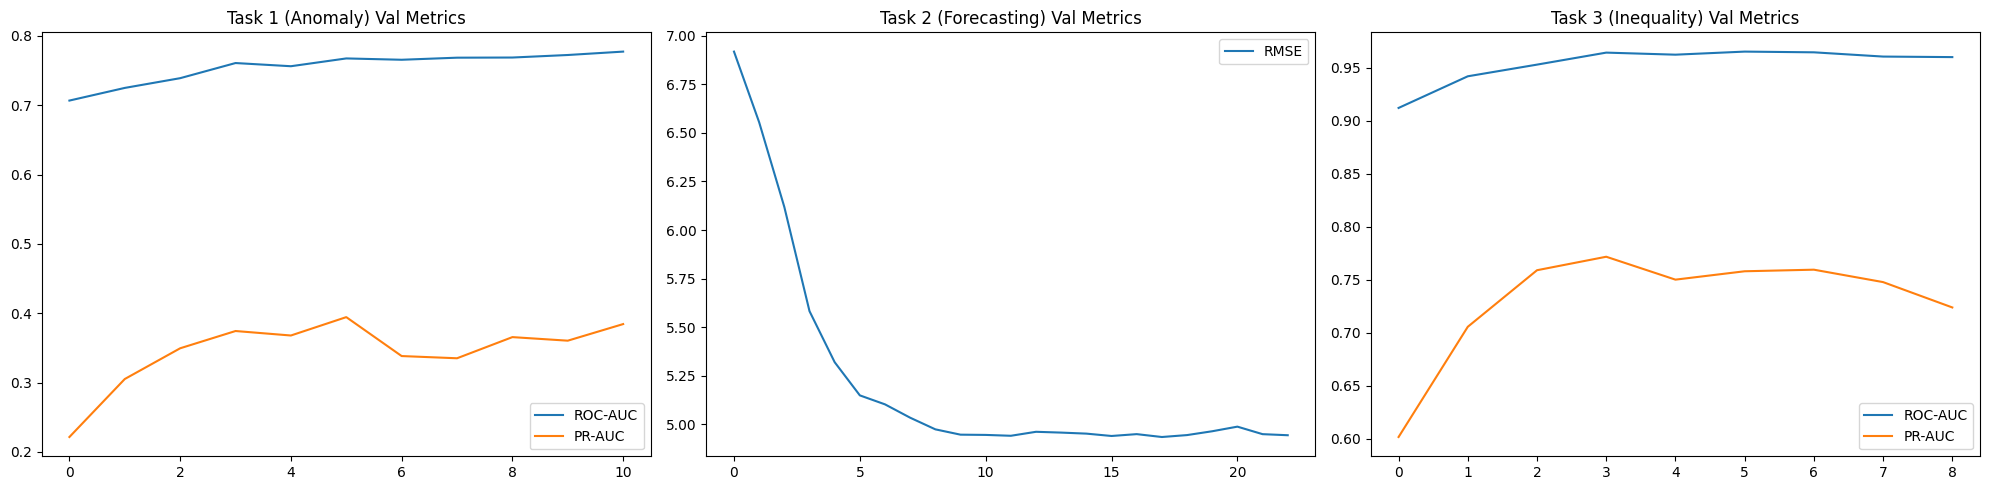

In [10]:
# Cell 10: Save Final Results & Compare
print("\n" + "="*60)
print("FINAL TABTRANSFORMER RESULTS")
print("="*60)

# Save results to CSV (as recommended)
results_df = pd.DataFrame(all_results)
results_df.to_csv("tabtransformer_results.csv", index=False)

print(results_df.to_markdown(index=False))

# Plot learning curves (as recommended)
try:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    # Task 1 Plot
    logs_t1_df = pd.DataFrame(all_logs['Task 1'])
    logs_t1_df[['ROC-AUC', 'PR-AUC']].plot(ax=axes[0], title='Task 1 (Anomaly) Val Metrics')
    
    # Task 2 Plot
    logs_t2_df = pd.DataFrame(all_logs['Task 2'])
    logs_t2_df[['RMSE']].plot(ax=axes[1], title='Task 2 (Forecasting) Val Metrics')
    
    # Task 3 Plot
    logs_t3_df = pd.DataFrame(all_logs['Task 3'])
    logs_t3_df[['ROC-AUC', 'PR-AUC']].plot(ax=axes[2], title='Task 3 (Inequality) Val Metrics')
    
    plt.tight_layout()
    plt.savefig('tabtransformer_learning_curves.png')
    plt.show()

except Exception as e:
    print(f"Could not plot learning curves: {e}")


INTERPRETABILITY: VISUALIZING EMBEDDINGS


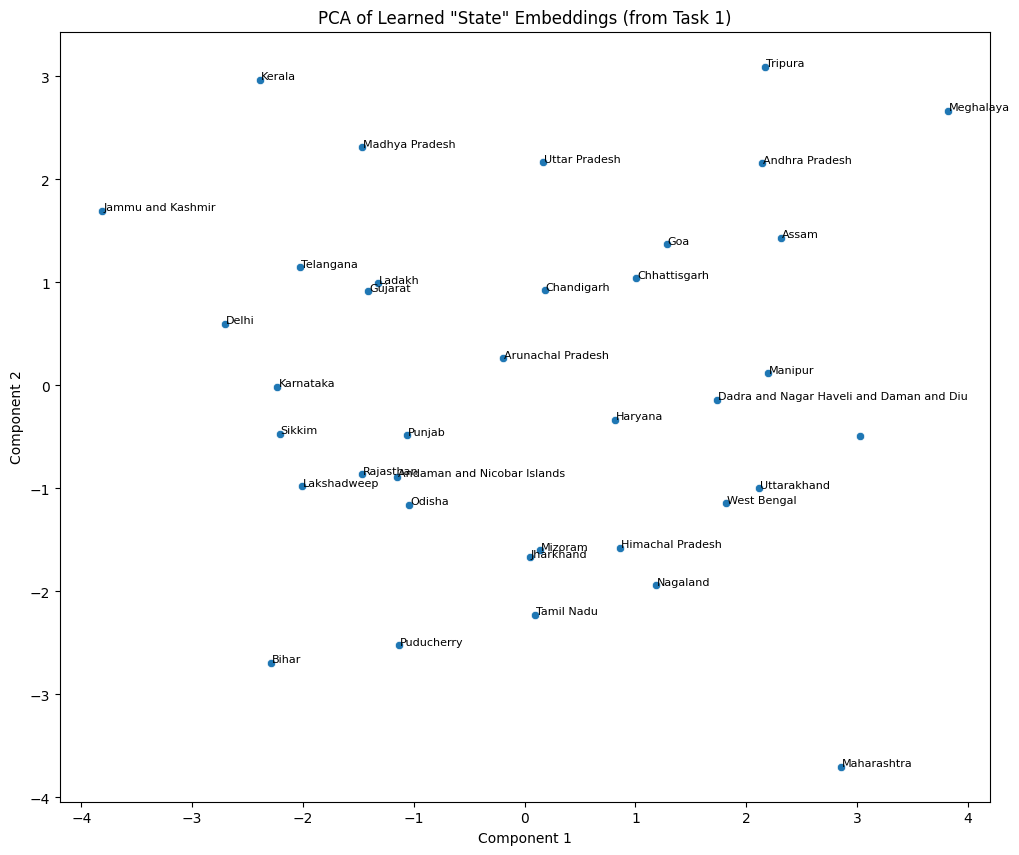

✓ Embedding visualization saved.


In [11]:
# Cell 11: Interpretability (Embedding Visualization)
# (As recommended in your plan)
print("\n" + "="*60)
print("INTERPRETABILITY: VISUALIZING EMBEDDINGS")
print("="*60)

try:
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # 1. Load the 'state' encoder
    encoders = joblib.load(os.path.join(CONFIG.ARTIFACTS_DIR, 'encoders.joblib'))
    state_encoder = encoders['state']
    
    # 2. Extract the 'state' embedding weights from the trained T1 model
    model_t1 = all_models['Task 1']
    state_embeddings = model_t1.category_embeddings['state'].weight.data.cpu().numpy()
    
    # 3. Reduce dimensions
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(state_embeddings)
    
    # 4. Create a DataFrame for plotting
    plot_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
    plot_df['state_name'] = state_encoder.classes_
    
    # 5. Plot
    plt.figure(figsize=(12, 10))
    sns.scatterplot(data=plot_df, x='x', y='y')
    
    # Add labels
    for i, row in plot_df.iterrows():
        if row['state_name'] != '<OTHER>':
            plt.text(row['x']+0.01, row['y'], row['state_name'], fontsize=8)
            
    plt.title('PCA of Learned "State" Embeddings (from Task 1)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.savefig('tabtransformer_embedding_visualization.png')
    plt.show()
    
    print("✓ Embedding visualization saved.")

except Exception as e:
    print(f"Could not run interpretability analysis: {e}")